In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import numpy as np

In [2]:
df = pd.read_excel('Downloads/online_retail_II.xlsx', dtype={'Invoice': str, 'Customer ID': str}, parse_dates=['InvoiceDate'], infer_datetime_format=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
Invoice        525461 non-null object
StockCode      525461 non-null object
Description    522533 non-null object
Quantity       525461 non-null int64
InvoiceDate    525461 non-null datetime64[ns]
Price          525461 non-null float64
Customer ID    417534 non-null object
Country        525461 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 32.1+ MB


In [4]:
df.dropna(subset=['Customer ID'], inplace=True)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0,12.758815,101.220424,-9360.0,2.00,4.00,12.00,19152.00
Price,417534.0,3.887547,71.131797,0.0,1.25,1.95,3.75,25111.09


In [6]:
df.loc[df.loc[:, 'Quantity'] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329,United Kingdom


In [7]:
number_of_orders_per_customer = df.groupby(['Customer ID'])['Invoice'].nunique() # количество заказов у каждого клиента
multiple_orders_proportion = np.sum(number_of_orders_per_customer > 1) / number_of_orders_per_customer.shape[0] # доля клиентов, сделавших больше одного заказа
print('{:.2%} of customers ordered more than once'.format(multiple_orders_proportion))

71.09% of customers ordered more than once


[Text(0, 0.5, '# of customers'),
 Text(0.5, 0, '# of orders'),
 Text(0.5, 1.0, 'Distribution of number of orders per customer')]

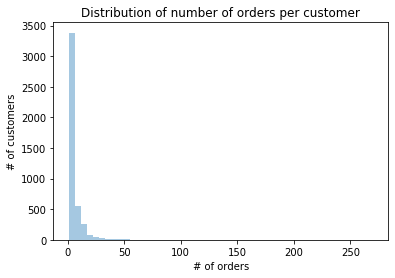

In [13]:
ax = sns.distplot(number_of_orders_per_customer, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel = '# of orders',
       ylabel = '# of customers')

In [14]:
df = df.loc[:, ['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates().reset_index(drop=True)

In [15]:
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

In [16]:
df

,Customer ID,Invoice,InvoiceDate,order_month,cohort
0,13085,489434,2009-12-01 07:45:00,2009-12,2009-12
1,13085,489435,2009-12-01 07:46:00,2009-12,2009-12
2,13078,489436,2009-12-01 09:06:00,2009-12,2009-12
3,15362,489437,2009-12-01 09:08:00,2009-12,2009-12
4,18102,489438,2009-12-01 09:24:00,2009-12,2009-12
...,...,...,...,...,...
23617,14713,538167,2010-12-09 18:58:00,2010-12,2009-12
23618,14702,538168,2010-12-09 19:23:00,2010-12,2009-12
23619,13230,538169,2010-12-09 19:28:00,2010-12,2010-03
23620,13969,538170,2010-12-09 19:32:00,2010-12,2010-03


In [17]:
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('Customer ID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort['order_month'] - df_cohort['cohort']).apply(attrgetter('n'))
df_cohort

,cohort,order_month,n_customers,period_number
0,2009-12,2009-12,1045,0
1,2009-12,2010-01,392,1
2,2009-12,2010-02,358,2
3,2009-12,2010-03,447,3
4,2009-12,2010-04,410,4
...,...,...,...,...
86,2010-10,2010-11,112,1
87,2010-10,2010-12,39,2
88,2010-11,2010-11,322,0
89,2010-11,2010-12,38,1


In [18]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,1045.0,392.0,358.0,447.0,410.0,408.0,408.0,374.0,355.0,392.0,452.0,518.0,260.0
2010-01,394.0,86.0,119.0,120.0,110.0,115.0,105.0,91.0,114.0,134.0,122.0,37.0,NaN
2010-02,363.0,109.0,82.0,110.0,93.0,76.0,79.0,103.0,100.0,106.0,32.0,NaN,NaN
2010-03,436.0,95.0,113.0,103.0,100.0,87.0,105.0,130.0,126.0,36.0,NaN,NaN,NaN
2010-04,291.0,67.0,58.0,47.0,54.0,67.0,79.0,76.0,22.0,NaN,NaN,NaN,NaN
2010-05,254.0,49.0,45.0,49.0,48.0,66.0,56.0,22.0,NaN,NaN,NaN,NaN,NaN
2010-06,269.0,58.0,53.0,55.0,62.0,76.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,183.0,38.0,37.0,52.0,55.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,158.0,39.0,50.0,51.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
cohort_size

cohort
2009-12    1045.0
2010-01     394.0
2010-02     363.0
2010-03     436.0
2010-04     291.0
2010-05     254.0
2010-06     269.0
2010-07     183.0
2010-08     158.0
2010-09     242.0
2010-10     379.0
2010-11     322.0
2010-12      47.0
Freq: M, Name: 0, dtype: float64

In [20]:
retention_matrix
retention_matrix.loc['2009-12']

period_number
0     1.000000
1     0.375120
2     0.342584
3     0.427751
4     0.392344
5     0.390431
6     0.390431
7     0.357895
8     0.339713
9     0.375120
10    0.432536
11    0.495694
12    0.248804
Name: 2009-12, dtype: float64

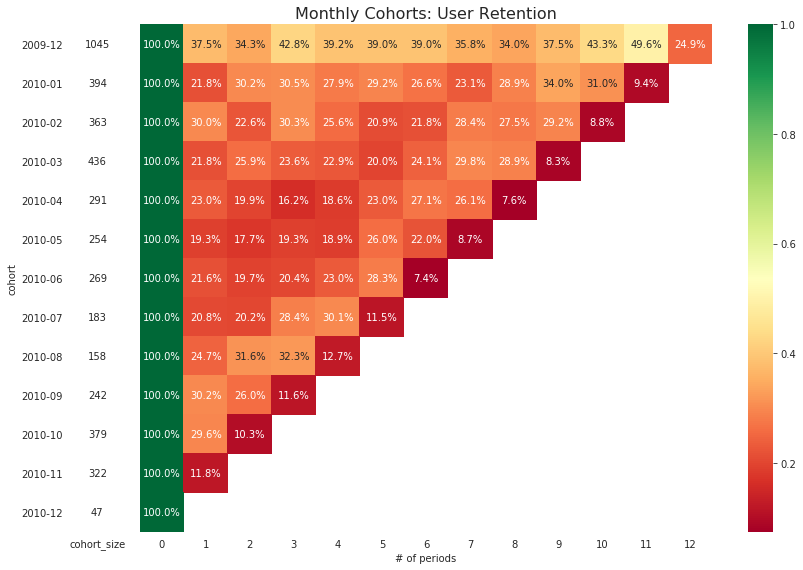

In [21]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True, gridspec_kw={'width_ratios': [1, 13]})
    
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.1%',
                cmap='RdYlGn',
                ax=ax[1])

    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')
    
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
    
    fig.tight_layout()